# Image Classification Batch Inference with PyTorch

# Step 1: Reading the Dataset from S3
Imagenette is a subset of Imagenet with 10 classes. We have this dataset hosted publicly in an S3 bucket. Since we are only doing inference here, we load in just the validation split.

Here, we use ray.data.read_images to load the validation set from S3. Ray Data also supports reading from a variety of other datasources and formats.

In [1]:
import ray

s3_uri = "s3://anonymous@air-example-data-2/imagenette2/train/"

ds = ray.data.read_images(s3_uri, mode="RGB")
ds

2024-02-29 11:20:58,561	INFO worker.py:1724 -- Started a local Ray instance.


Dataset(
   num_blocks=200,
   num_rows=9469,
   schema={image: numpy.ndarray(ndim=3, dtype=uint8)}
)

In [2]:
ds.schema()

Column  Type
------  ----
image   numpy.ndarray(ndim=3, dtype=uint8)

# Step 2: Inference on a single batch
Next, we can do inference on a single batch of data, using a pre-trained ResNet152 model and following this PyTorch example.

Let’s get a batch of 10 from our dataset. Each image in the batch is represented as a Numpy array.

2024-02-29 12:13:16,894	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=200 for stage ReadImage to satisfy DataContext.get_current().min_parallelism=200.


2024-02-29 12:13:16,901	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage] -> LimitOperator[limit=10]
2024-02-29 12:13:16,906	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2024-02-29 12:13:16,908	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

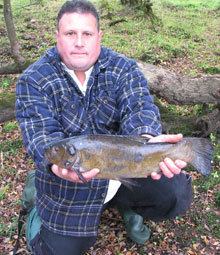

(autoscaler +52m56s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


(raylet) [2024-02-29 12:13:58,538 E 216199 216199] (raylet) node_manager.cc:3024: 3 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: fcb415371670b6d3748ba5a963c75b35f9fe6fc6c74cab0d737c412c, IP: 192.168.31.225) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.31.225`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(autoscaler +53m31s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +54m6s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +54m41s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +55m16s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +55m51s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +56m26s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to r

In [15]:
single_batch = ds.take_batch(10)

from PIL import Image

img = Image.fromarray(single_batch["image"][5])
img

Now, let’s download a pre-trained PyTorch Resnet model and get the required preprocessing transforms to preprocess the images prior to prediction.

In [4]:
import torch
from torchvision.models import ResNet152_Weights
from torchvision import transforms
from torchvision import models

weights = ResNet152_Weights.IMAGENET1K_V1

# Load the pretrained resnet model and move to GPU if one is available.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(weights=weights).to(device)
model.eval()

imagenet_transforms = weights.transforms
transform = transforms.Compose([transforms.ToTensor(), imagenet_transforms()])

Then, we apply the transforms to our batch of images, and pass the batch to the model for inference, making sure to use the GPU device for inference.

We can see that most of the images in the batch have been correctly classified as “tench” which is a type of fish.

In [5]:
transformed_batch = [transform(image) for image in single_batch["image"]]
with torch.inference_mode():
    prediction_results = model(torch.stack(transformed_batch).to(device))
    classes = prediction_results.argmax(dim=1).cpu()

del model  # Free up GPU memory

labels = [weights.meta["categories"][i] for i in classes]
labels

['tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'coho',
 'tench',
 'tench']

# Step 3: Scaling up to the full Dataset with Ray Data
By using Ray Data, we can apply the same logic in the previous section to scale up to the entire dataset, leveraging all the GPUs in our cluster.

### Preprocessing
First let’s convert the preprocessing code to Ray Data. We’ll package the preprocessing code within a preprocess_image function. This function should take only one argument, which is a dict that contains a single image in the dataset, represented as a numpy array. We use the same transform function that was defined above and store the transformed image in a new transformed_image field.

In [6]:
import numpy as np
from typing import Any, Dict

def preprocess_image(row: Dict[str, np.ndarray]):
    return {
        "original_image": row["image"],
        "transformed_image": transform(row["image"]),
    }

Then we use the map() API to apply the function to the whole dataset row by row. We use this instead of map_batches() because the torchvision transforms must be applied one image at a time due to the dataset containing images of different sizes.

By using Ray Data’s map, we can scale out the preprocessing to utilize all the resources in our Ray cluster.



In [7]:
transformed_ds = ds.map(preprocess_image)

### Model Inference
Next, let’s convert the model inference part. Compared with preprocessing, model inference has 2 differences:

Model loading and initialization is usually expensive.

Model inference can be optimized with hardware acceleration if we process data in batches. Using larger batches improves GPU utilization and the overall runtime of the inference job.

Thus, we convert the model inference code to the following ResnetModel class. In this class, we put the expensive model loading and initialization code in the __init__ constructor, which will run only once. And we put the model inference code in the __call__ method, which will be called for each batch.

The __call__ method takes a batch of data items, instead of a single one. In this case, the batch is also a dict that has the "transformed_image" key populated by our preprocessing step, and the value is a Numpy array of images represented in np.ndarray format. We reuse the same inferencing logic from step 2.

In [8]:
from typing import Dict
import numpy as np
import torch


class ResnetModel:
    def __init__(self):
        self.weights = ResNet152_Weights.IMAGENET1K_V1
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = models.resnet152(weights=self.weights).to(self.device)
        self.model.eval()

    def __call__(self, batch: Dict[str, np.ndarray]):
        # Convert the numpy array of images into a PyTorch tensor.
        # Move the tensor batch to GPU if available.
        torch_batch = torch.from_numpy(batch["transformed_image"]).to(self.device)
        with torch.inference_mode():
            prediction = self.model(torch_batch)
            predicted_classes = prediction.argmax(dim=1).detach().cpu()
            predicted_labels = [
                self.weights.meta["categories"][i] for i in predicted_classes
            ]
            return {
                "predicted_label": predicted_labels,
                "original_image": batch["original_image"],
            }

Then we use the map_batches() API to apply the model to the whole dataset.

The first parameter of map_batches is the user-defined function (UDF), which can either be a function or a class. Because this case uses a class, the UDF runs as long-running Ray actors. For class-based UDFs, use the concurrency argument to specify the number of parallel actors.

The batch_size argument indicates the number of images in each batch. See the Ray dashboard for GPU memory usage to experiment with the batch_size when using your own model and dataset. You should aim to max out the batch size without running out of GPU memory.

The num_gpus argument specifies the number of GPUs needed for each ResnetModel instance. In this case, we want 1 GPU for each model replica. If you are doing CPU inference, you can remove the num_gpus=1.

In [18]:
predictions = transformed_ds.map_batches(
    ResnetModel,
    concurrency=1,  # Use 4 GPUs. Change this number based on the number of GPUs in your cluster.
    num_gpus=0,  # Specify 1 GPU per model replica.
    batch_size=1,  # Use the largest batch size that can fit on our GPUs
)

# Verify and Save Results
Let’s take a small batch of predictions and verify the results.

In [19]:
prediction_batch = predictions.take_batch(5)

2024-02-29 12:20:12,499	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=200 for stage ReadImage to satisfy DataContext.get_current().min_parallelism=200.
2024-02-29 12:20:12,501	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[ReadImage->Map(preprocess_image)->MapBatches(ResnetModel)] -> LimitOperator[limit=5]
2024-02-29 12:20:12,502	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2024-02-29 12:20:12,505	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


2024-02-29 12:20:14,018	INFO actor_pool_map_operator.py:114 -- ReadImage->Map(preprocess_image)->MapBatches(ResnetModel): Waiting for 1 pool actors to start...


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(autoscaler +59m57s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +1h32s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


2024-02-29 12:21:28,982	WARNING actor_pool_map_operator.py:278 -- To ensure full parallelization across an actor pool of size 1, the Dataset should consist of at least 1 distinct blocks. Consider increasing the parallelism when creating the Dataset.


KeyboardInterrupt: 

(autoscaler +1h1m7s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


In [ ]:
from PIL import Image

for image, prediction in zip(
    prediction_batch["original_image"], prediction_batch["predicted_label"]
):
    img = Image.fromarray(image)
    display(img)
    print("Label: ", prediction)

NameError: name 'prediction_batch' is not defined

(autoscaler +1h36m48s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


(raylet) [2024-02-28 18:13:10,356 E 183831 183831] (raylet) node_manager.cc:3024: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: e3c38588c9e2f9f36c419158cd20dd824436b2f1718d0024a50fd7f3, IP: 192.168.31.225) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.31.225`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(autoscaler +1h37m23s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +1h37m58s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


(raylet) [2024-02-28 18:14:10,358 E 183831 183831] (raylet) node_manager.cc:3024: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: e3c38588c9e2f9f36c419158cd20dd824436b2f1718d0024a50fd7f3, IP: 192.168.31.225) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.31.225`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(autoscaler +1h38m33s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +1h39m8s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +1h39m43s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +1h40m18s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +1h40m53s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +1h41m28s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this 

(raylet) [2024-02-28 19:17:10,437 E 183831 183831] (raylet) node_manager.cc:3024: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: e3c38588c9e2f9f36c419158cd20dd824436b2f1718d0024a50fd7f3, IP: 192.168.31.225) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.31.225`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(autoscaler +2h41m39s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +2h42m14s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +2h42m49s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +2h43m24s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +2h43m59s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +2h44m34s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this

(raylet) [2024-02-28 20:06:10,674 E 183831 183831] (raylet) node_manager.cc:3024: 18 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: e3c38588c9e2f9f36c419158cd20dd824436b2f1718d0024a50fd7f3, IP: 192.168.31.225) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.31.225`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(autoscaler +3h30m45s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


(raylet) [2024-02-28 20:07:11,244 E 183831 183831] (raylet) node_manager.cc:3024: 17 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: e3c38588c9e2f9f36c419158cd20dd824436b2f1718d0024a50fd7f3, IP: 192.168.31.225) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.31.225`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(autoscaler +3h31m23s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +3h31m59s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


(raylet) [2024-02-28 20:08:11,334 E 183831 183831] (raylet) node_manager.cc:3024: 34 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: e3c38588c9e2f9f36c419158cd20dd824436b2f1718d0024a50fd7f3, IP: 192.168.31.225) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.31.225`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(autoscaler +3h32m34s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +3h33m9s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


(raylet) [2024-02-28 20:09:11,337 E 183831 183831] (raylet) node_manager.cc:3024: 15 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: e3c38588c9e2f9f36c419158cd20dd824436b2f1718d0024a50fd7f3, IP: 192.168.31.225) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.31.225`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(autoscaler +3h33m45s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
